In [1]:
import pandas as pd
import numpy as np
import sys, os
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from MetaIPM import network
from MetaIPM import populated_network
from MetaIPM import stochastic_wrapper as sw
from MetaIPM import summarize_outputs as so
from MetaIPM import recruitment
data_file_path = "./ModelData/"

In [2]:
network_file = "network.csv"
transition_probs = "psi.csv"
transition_key = "psi_key.csv"
node_file = "node.csv"
group_file = "group_details.csv"
lw_file = "LW_Pool.csv"
vonB_file = "vonB.csv"
vonB_sigma_file = "vonB_sigma.csv"
maturity_file = "maturity.csv"

In [3]:
network_data = pd.read_csv(data_file_path + network_file)
transition_data = pd.read_csv(data_file_path  + transition_probs)
transition_key_data = pd.read_csv(data_file_path  + transition_key)
node_data = pd.read_csv(data_file_path + node_file)
group_data = pd.read_csv(data_file_path + group_file)
lw_data = pd.read_csv(data_file_path + lw_file)
vonB_data = pd.read_csv(data_file_path + vonB_file)
vonB_sigma_data = pd.read_csv(data_file_path + vonB_sigma_file)
maturity_data = pd.read_csv(data_file_path + maturity_file)

In [4]:
def make_model():
    deterministic_model = populated_network.populate_network_from_csv(
        network_data = network_data,
        transition_data = transition_data,
        transition_key_data = transition_key_data,
        node_data = node_data,
        group_data = group_data,
        lw_data = lw_data,
        vonB_data = vonB_data,
        vonB_sigma_data = vonB_sigma_data,
        maturity_data = maturity_data,
        stochastic_spawn = False,
        stochastic_pars = False
        ).show_network()
    return deterministic_model

In [5]:
def graph_results(deterministic_model, title, suppress_graph=False):
    out_all = so.extract_all_populations(deterministic_model)
    out_all = out_all[out_all["Year"] < out_all["Year"].max()]

    out_by_node = out_all.groupby(['Year','Month','Node'])[['Population']].sum().reset_index()
    out_by_node["Months"] = out_by_node["Month"] + out_by_node["Year"]
    out_by_node = out_by_node[out_by_node["Month"] == 0]
    out_by_node['Years'] = out_by_node['Months']
    a = out_by_node[out_by_node['Node'] == 'a']
    last_a = a['Population'].values[-1]
    b = out_by_node[out_by_node['Node'] == 'b']
    last_b = b['Population'].values[-1]
    
    if suppress_graph:
        return last_a, last_b
    
    # Plot Nodes
    fig, axs = plt.subplots(1, 2, sharey=True,
                           subplot_kw={'box_aspect':1},
                           gridspec_kw={'wspace':0.05})
    plt.style.use('seaborn-whitegrid')
    
    ## La Grange
    plt.sca(axs[0])
    plt.plot(a['Years'], a['Population'])
    plt.title('La Grange', fontsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Population', fontsize=15)
    plt.yticks([0, 100_000, 200_000, 300_000, 400_000],
               ['0', '100,000', '200,000', '300,000', '400,000'])
    
    
    ## Peoria
    plt.sca(axs[1])
    plt.plot(b['Years'], b['Population'])
    plt.title('Peoria', fontsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Population', fontsize=15)
    axs[1].label_outer()

    ## General
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.95)
    plt.ylim(0, 430000)
    plt.savefig(f'{title}.png', bbox_inches='tight')
    plt.show()
    return last_a, last_b

In [6]:
def test_model(g, title, suppress_graph=False):
    mask = vonB_data['parameter'] == 'g_migration'
    default = vonB_data.loc[mask, 'V1']
    vonB_data.loc[mask, 'V1'] = g
    model = make_model()
    model.project_network()
    results = graph_results(model, title, suppress_graph)
    vonB_data.loc[mask, 'V1'] = default
    return results

In [7]:
a_s = []
b_s = []
for i in np.linspace(-16, -3, 53):
    title = f'No Harvesting, g=10^{i}'
    last_a, last_b = test_model(10**i, title, True)
    a_s.append(last_a)
    b_s.append(last_b)

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

<Figure size 432x288 with 0 Axes>

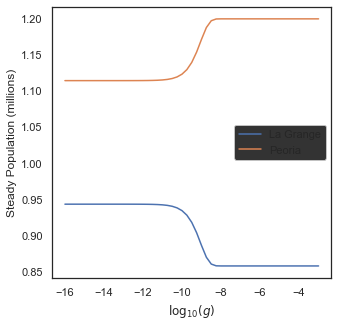

In [8]:
plt.tight_layout()
a_s = np.array(a_s)
b_s = np.array(b_s)

plt.figure(figsize=(5,5))
plt.plot(np.linspace(-16, -3, 53), a_s/1_000_000, label='La Grange')
plt.plot(np.linspace(-16, -3, 53), b_s/1_000_000, label='Peoria')
plt.xlabel(r'$\log_{10}(g)$')
plt.ylabel('Steady Population (millions)')
#plt.title('Effects of Competition on Steady Population', fontsize=20)
plt.legend(loc='center right', frameon=True)
#plt.yticks([300_000, 350_000, 400_000],
#           ['300,000', '350,000', '400,000'])
plt.savefig('Graphics/MigrationSteadyInteraction.png', bbox_inches='tight')

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

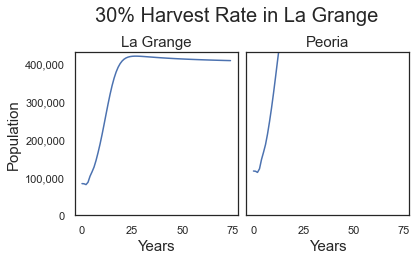

(407299.3395280457, 633885.4936923432)

In [9]:
title = '30% Harvest Rate in La Grange'
mask = node_data['Pool'] == 'a'
node_data.loc[mask, 'harvest_max'] = 0.6

test_model(10**-7, title)

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

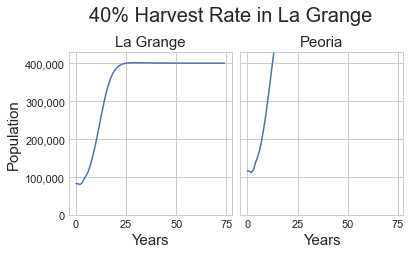

(400573.10672731115, 627585.7566878722)

In [10]:
title = '40% Harvest Rate in La Grange'
mask = node_data['Pool'] == 'a'
node_data.loc[mask, 'harvest_max'] = 0.8

test_model(10**-7, title)

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

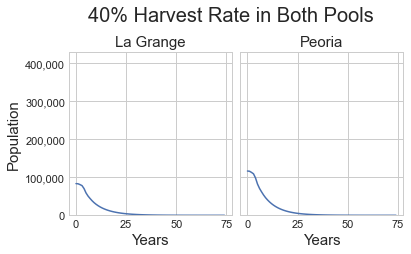

(6.6565876013969225, 7.860959974233234)

In [11]:
title = '40% Harvest Rate in Both Pools'
mask = node_data['Pool'] == 'b'
node_data.loc[mask, 'harvest_max'] = 0.8

test_model(10**-7, title)

In [12]:
model = make_model()
model.project_network()

out_all = so.extract_all_populations(model)
out_all = out_all[out_all["Year"] == 5]

C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\network.py:171: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  transition_data_use['prob'] = transition_data_use.iloc[
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  self.vonB_data['pars'] = self.vonB_data[vonB_columns].mean(1)
C:\Users\camer\anaconda3\lib\site-packages\metaipm_rerickson_usgs-1.0.0-py3.9.egg\MetaIPM\node.py:104: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this wil

In [13]:
out_all

,Year,Month,Node,Group,Length,Population
5,5,0,a,Male,9.910891,5.781601e-39
81,5,0,a,Male,19.811782,3.309649e-36
157,5,0,a,Male,29.712673,4.252428e-34
233,5,0,a,Male,39.613564,2.864301e-32
309,5,0,a,Male,49.514455,1.319648e-30
...,...,...,...,...,...,...
7225,5,0,b,Female,950.495545,9.487646e-03
7301,5,0,b,Female,960.396436,4.017649e-03
7377,5,0,b,Female,970.297327,1.636117e-03
7453,5,0,b,Female,980.198218,6.405028e-04


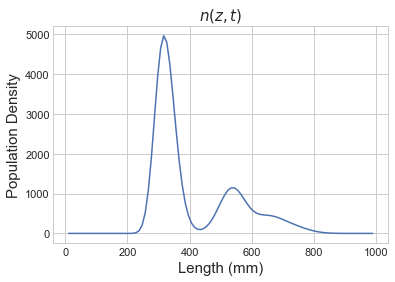

In [14]:
out_by_node = out_all.groupby(['Length','Node'])[['Population']].sum().reset_index()
a = out_by_node[out_by_node['Node'] == 'a']

plt.plot(a['Length'], a['Population'])
plt.title(r'$n(z,t)$', fontsize=15)
plt.xlabel('Length (mm)', fontsize=15)
plt.ylabel('Population Density', fontsize=15)

plt.savefig('Graphics/pop_density.svg', bbox_inches='tight')

In [15]:
out_by_node

,Length,Node,Population
0,9.910891,a,1.156320e-38
1,9.910891,b,1.615965e-38
2,19.811782,a,6.619297e-36
3,19.811782,b,9.250512e-36
4,29.712673,a,8.504856e-34
...,...,...,...
195,970.297327,b,3.272234e-03
196,980.198218,a,9.166366e-04
197,980.198218,b,1.281006e-03
198,990.099109,a,3.448167e-04
